In [1]:
!pip install hydra-core fairlearn numpy pandas scikit-learn xgboost matplotlib seaborn


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
import numpy as np
import pandas as pd
import random
import hydra


from sklearn.metrics import balanced_accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
import xgboost

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds

from Evaluation.metrics import EvalMetrics
from Evaluation.fairness import EvalFairness
from Visualization.fairness import VisualizationFairness
from Modules.Fairness.fairness_mitigation import ExponentiatedGradientMitigation
from Utils.file import *
from Trainer.train_ml import MLTrainer

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setting up the configuration using Hydra
with hydra.initialize(version_base='1.3', config_path="Conf"):
    cfg = hydra.compose(config_name="config.yaml")

# Setting environment variables for reproducibility
os.environ["PYTHONHASHSEED"] = str(cfg.seed)
random.seed(cfg.seed)
np.random.seed(cfg.seed)

# Creating necessary directories for checkpoints and saving outputs
save_path = os.path.join(cfg.path.plot_path, cfg.train.model_name) #, cfg.log.time)
origin_save_path = save_path
os.makedirs(save_path, exist_ok=True)

# 1. **MIMIC-IV ICU Data**
* **Key columns**: Columns uniquely identifying each individual or hospital admission
* **Protected Attributes**: Protected attributes for fairness analysis (gender, race, age, insurance type)

In [4]:
# Loading the dataset (derived from the MIMIC database) for training, validation, and testing
train_data = pd.read_csv(os.path.join(cfg.path.preprocessed_data_path, 'MIMIC_IV_train.csv'))
valid_data = pd.read_csv(os.path.join(cfg.path.preprocessed_data_path, 'MIMIC_IV_valid.csv'))
test_data = pd.read_csv(os.path.join(cfg.path.preprocessed_data_path, 'MIMIC_IV_test.csv'))

train_data.head(10)

,subject_id,hadm_id,stay_id,age,los,gender,race,insurance,mort_hosp,so2,...,phenylephrine,vasopressin,dobutamine,milrinone,crrt,rbc trans,platelets trans,ffp trans,colloid bolus,crystalloid bolus
0,10001725,25563031,31205490,"[40, 50)",1.33,F,WHITE,Other,0.0,98.166667,...,0.244679,0.370840,0.356545,0.398227,0.360851,0.089679,0.044803,0.051864,0.072551,0.080128
1,10001884,26184834,37510196,"[70, 80)",9.17,F,BLACK,Medicare,1.0,97.504950,...,0.244679,0.370840,0.356545,0.398227,0.360851,0.089679,0.044803,0.051864,0.072551,0.080128
2,10002013,23581541,39060235,"[50, 60)",1.29,F,OTHER,Medicare,0.0,96.621212,...,0.031250,0.370840,0.356545,0.398227,0.360851,0.089679,0.044803,0.051864,0.062500,0.093750
3,10002428,28662225,33987268,"[80, 90)",4.96,F,WHITE,Medicare,0.0,97.741738,...,0.244679,0.370840,0.356545,0.398227,0.360851,0.089679,0.044803,0.051864,0.072551,0.216667
4,10002443,21329021,35044219,"[50, 60)",2.75,M,WHITE,Other,0.0,92.751323,...,0.244679,0.370840,0.356545,0.398227,0.360851,0.089679,0.044803,0.051864,0.072551,0.014925
5,10002495,24982426,36753294,"[80, 90)",5.08,M,UNKNOWN,Medicare,0.0,97.439316,...,0.016260,0.370840,0.356545,0.398227,0.360851,0.089679,0.044803,0.051864,0.072551,0.040650
6,10002930,25696644,37049133,"[50, 60)",1.13,F,BLACK,Medicare,0.0,97.420000,...,0.244679,0.370840,0.356545,0.398227,0.360851,0.089679,0.044803,0.051864,0.072551,0.080128
7,10003019,22774359,30676350,"[70, 80)",0.71,M,WHITE,Medicare,0.0,96.937500,...,0.333333,0.370840,0.356545,0.398227,0.360851,0.089679,0.044803,0.051864,0.072551,0.080128
8,10004113,29879900,35200789,"[30, 40)",1.04,M,WHITE,Other,0.0,98.500000,...,0.244679,0.370840,0.356545,0.398227,0.360851,0.089679,0.044803,0.051864,0.072551,0.080128
9,10004235,24181354,34100191,"[40, 50)",4.92,M,BLACK,Medicaid,0.0,96.187462,...,0.630252,0.739496,0.356545,0.398227,0.344538,0.089679,0.075630,0.051864,0.072551,0.033613


In [5]:
train_data.shape, valid_data.shape, test_data.shape

((30414, 105), (4348, 105), (8703, 105))

In [6]:
# Define key columns and protected attributes
key_col = ['subject_id', 'hadm_id', 'stay_id']
protected_attributes = ['gender', 'race', 'age', 'insurance']

* Check the distribution of In-hospital Mortality data by protected attributes

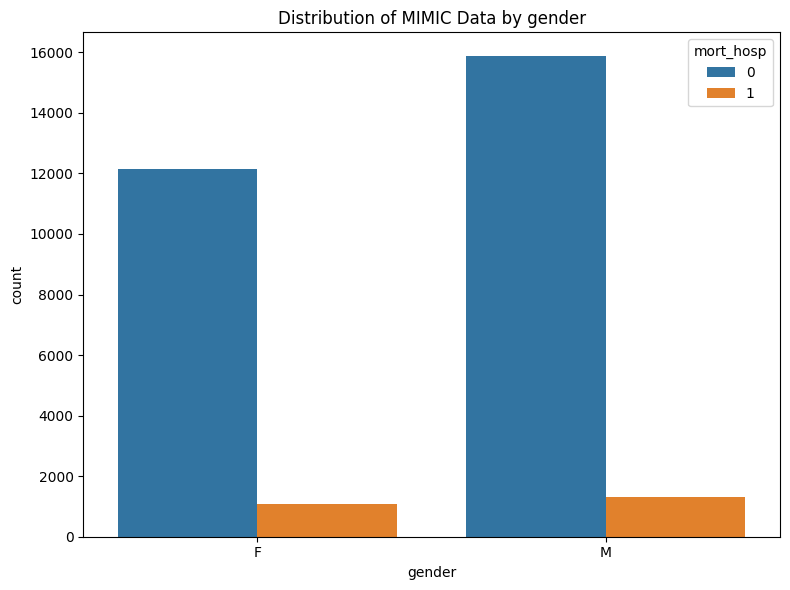

In [7]:
# Set 'gender' as the protected attribute for analysis
protected_attribute = 'gender'

plt.figure(figsize=(8, 6))
sns.countplot(train_data, x=protected_attribute, hue='mort_hosp', 
              hue_order=[0, 1])
plt.title(f'Distribution of MIMIC Data by {protected_attribute}')
plt.tight_layout()
plt.show()

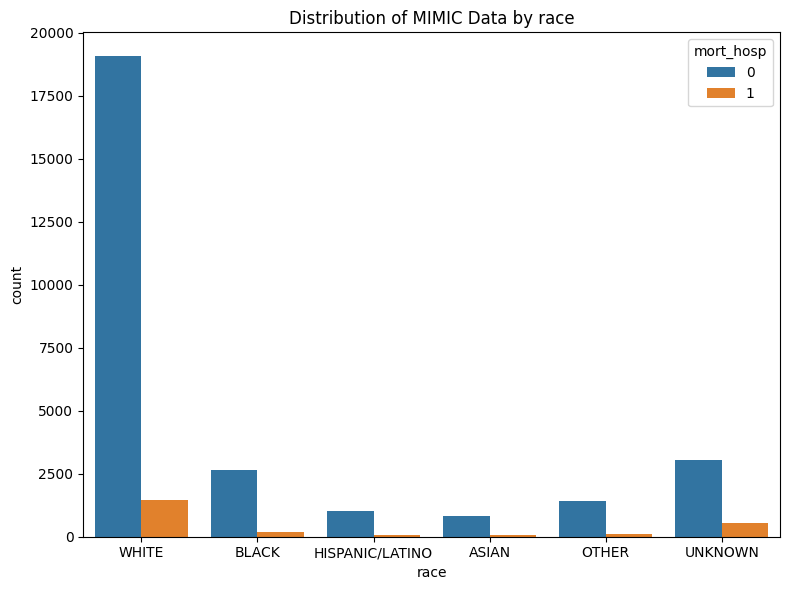

In [8]:
protected_attribute = 'race'

plt.figure(figsize=(8, 6))
sns.countplot(train_data, x=protected_attribute, hue='mort_hosp', 
              hue_order=[0, 1], order=['WHITE', 'BLACK', 'HISPANIC/LATINO', 'ASIAN', 'OTHER', 'UNKNOWN'])
plt.title(f'Distribution of MIMIC Data by {protected_attribute}')
plt.tight_layout()
plt.show()

* Patient Age Categories (Age): 18-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89

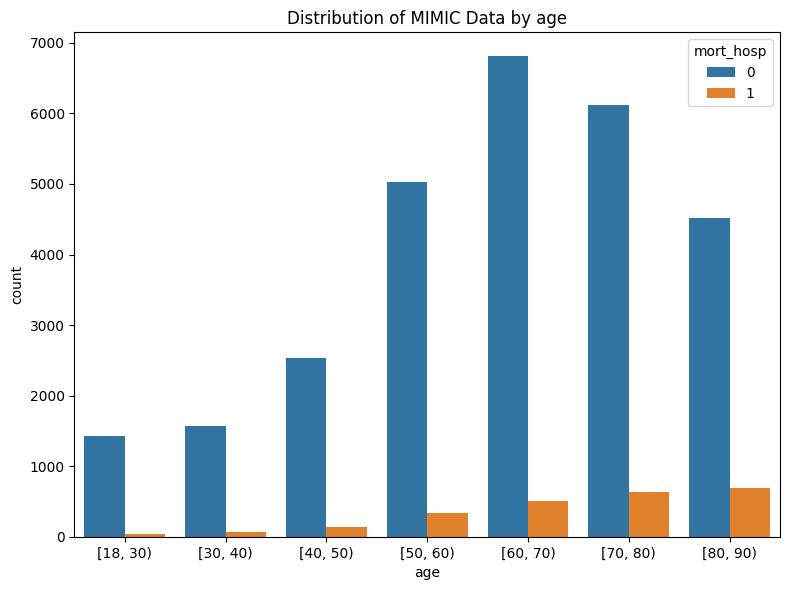

In [9]:
protected_attribute = 'age'

plt.figure(figsize=(8, 6))
sns.countplot(train_data, x=protected_attribute, hue='mort_hosp', 
              hue_order=[0, 1], order=['[18, 30)', '[30, 40)', '[40, 50)', '[50, 60)', '[60, 70)', '[70, 80)', '[80, 90)'])
plt.title(f'Distribution of MIMIC Data by {protected_attribute}')
plt.tight_layout()
plt.show()

* Patient Insurance Type Classification (Insurance): 
  - **Medicare**: Federal health insurance program for individuals 65 and older and certain disabled persons
  - **Medicaid**: Jointly run federal and state health insurance program for low-income individuals
  - **Other**

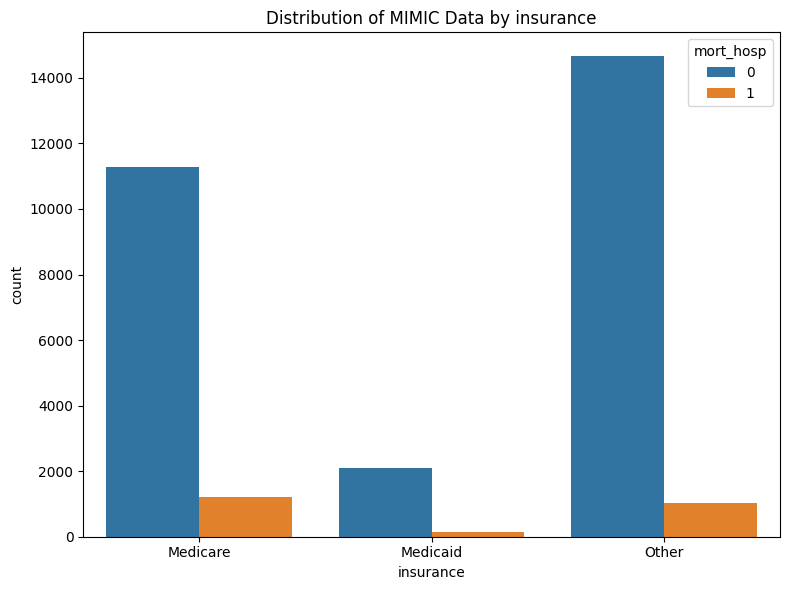

In [10]:
protected_attribute = 'insurance'

plt.figure(figsize=(8, 6))
sns.countplot(train_data, x=protected_attribute, hue='mort_hosp', 
              hue_order=[0, 1], order=['Medicare', 'Medicaid', 'Other'])
plt.title(f'Distribution of MIMIC Data by {protected_attribute}')
plt.tight_layout()
plt.show()

# **2. Model Evaluation**
**: Assessing AI model fairness in Mortality Prediction tasks and validating the effect of mitigation algorithms**

### 1) Model Performance Evaluation
* **Accuracy**: Overall correctness of predictions
* **Balanced Accuracy**: Accuracy considering class imbalance
* **Precision**: Proportion of positive predictions that are correct
* **Recall**: Proportion of actual positives correctly identified
* **F1-Score**: Harmonic mean of Precision and Recall
* **AUC**: Area Under the Receiver Operating Characteristic (ROC) Curve

### 2) Model Fairness Evaluation
* **Demographic Parity**  
  : The model’s prediction outcomes should have the same rate across all groups.
    * [Demographic Parity Difference](https://fairlearn.org/main/api_reference/generated/fairlearn.metrics.demographic_parity_difference.html): Difference in prediction rates across groups.
    * [Demographic Parity Ratio](https://fairlearn.org/main/api_reference/generated/fairlearn.metrics.demographic_parity_ratio.html): Ratio between the selection rate of the smallest and largest groups.

* **Equalized Odds**  
  : The true positive rate and false positive rate should be equal across all groups. Ensures no group has a higher likelihood of receiving positive outcomes.
    * [Equalized Odds Difference](https://fairlearn.org/main/api_reference/generated/fairlearn.metrics.equalized_odds_difference.html): Maximum of the differences in true positive rate and false positive rate across groups. An equalized odds difference of 0 implies all groups share the same rates for true positives, true negatives, false positives, and false negatives.
    * [Equalized Odds Ratio](https://fairlearn.org/main/api_reference/generated/fairlearn.metrics.demographic_parity_difference.html): Minimum ratio of true positive and false positive rates across groups. An equalized odds ratio of 1 indicates that all groups have the same rates for true positives, true negatives, false positives, and false negatives.

In [11]:
# Label for Mortality Prediction Task
# mort_hosp: In-hospital mortality status
target_col = 'mort_hosp'

# Choose a subset of variables
categorical_cols = ['age', 'gender', 'race', 'insurance', 'vent', 'antibiotic', 'dopamine', 
                    'epinephrine', 'norepinephrine','phenylephrine', 'vasopressin', 
                    'dobutamine', 'milrinone', 'crrt', 'rbc trans', 'platelets trans', 
                    'ffp trans', 'colloid bolus', 'crystalloid bolus']

numerical_cols =['los', 'so2', 'po2', 'pco2', 'fio2', 'ph', 'temperature', 'heart_rate', 'hemoglobin', 
                 'sbp', 'dbp', 'mbp', 'sbp_ni', 'dbp_ni', 'mbp_ni', 'resp_rate', 'gcs',
                 'albumin', 'glucose', 'Red blood cell count urine', 'White blood cell count urine', 'pH urine',
                 'Tidal Volume Observed', 'Total Protein Urine', 'Central Venous Pressure', 'Creatinine urine',
                 'Magnesium', 'Peak inspiratory pressure', 'Phosphate', 'Plateau Pressure', 'Positive end-expiratory pressure']

In [12]:
# Define Pipeline for Preprocessing Numerical Data: Transform values to a range between 0 and 1 using Min-Max Scaler
numeric_transformer = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
    ]
)
# Define Pipeline for Preprocessing Categorical Data: Encode categorical variables using One-Hot Encoding
categorical_transformer = Pipeline(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore")),
    ]
)
# Pipeline for Preprocessing Entire Dataset
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category")),
    ]
)

In [13]:
# Model: XGBoost
model = xgboost.XGBClassifier(eval_metric='logloss',
                             learning_rate=0.1,
                             max_depth=5,
                             n_estimators=150,
                             num_round=300,
                             objective='binary:logistic')
# Define Model Name
model_name = 'XGBoost'

# Set path to save model results
save_path = os.path.join(origin_save_path, model_name)

estimator = Pipeline(
    steps=[
        ("preprocessor", preprocessor), # Preprocessing step
        ("classifier", model), # Classifier step
    ]
)

trainer = MLTrainer(cfg, model=model, save_path=save_path, preprocessor=preprocessor)

In [14]:
unmitigated_model_save_path = os.path.join(save_path, 'unmitigated')

# Train Model Without Applying Mitigation Algorithms
estimator = trainer.train(estimator=estimator,
                          discrete_cols=categorical_cols,
                          continuous_cols=numerical_cols)

### 2.1) Model Performance Evaluation

[Evaluation: Performance Metrics]

accuracy: 0.947
balanced_accuracy: 0.726
precision: 0.733
recall: 0.465
f1 score: 0.569
AUC: 0.929
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      8054
         1.0       0.73      0.47      0.57       649

    accuracy                           0.95      8703
   macro avg       0.85      0.73      0.77      8703
weighted avg       0.94      0.95      0.94      8703



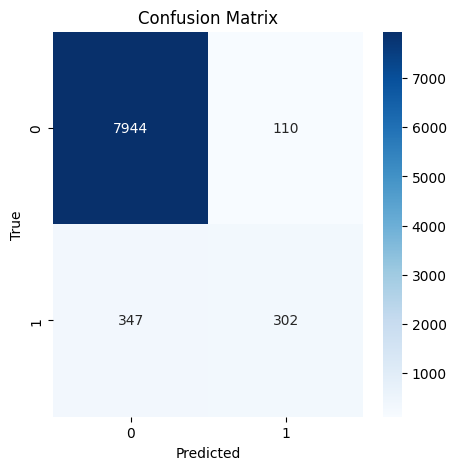

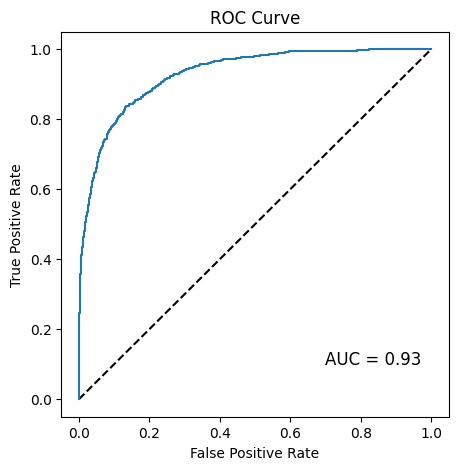

In [15]:
estimator = trainer.eval(estimator=estimator,
                         discrete_cols=categorical_cols,
                         continuous_cols=numerical_cols,
                         protected_attribute=protected_attribute,
                         save_path=unmitigated_model_save_path)

### 2.2) Model Fairness Evaluation 
### **Protected Attribute: Race**

* Model Evaluation Performance by Protected Attribute Groups
* Selection Rate: The proportion of each group that has a positive label in the dataset

[Fairness Evaluation: Fairness Metrics]

=== By Group ===
                 balanced_accuracy  precision    recall  false_positive_rate  \
race                                                                           
ASIAN                     0.729998   0.714286  0.476190             0.016194   
BLACK                     0.644652   0.652174  0.300000             0.010695   
HISPANIC/LATINO           0.831585   0.888889  0.666667             0.003497   
OTHER                     0.760170   0.620690  0.545455             0.025114   
UNKNOWN                   0.764499   0.790476  0.553333             0.024336   
WHITE                     0.713429   0.724138  0.438642             0.011784   

                 false_negative_rate  selection_rate  
race                                                  
ASIAN                       0.523810        0.052239  
BLACK                       0.700000        0.028822  
HISPANIC/LATINO             0.333333        0.030201  
OTHER                     

<Figure size 800x600 with 0 Axes>

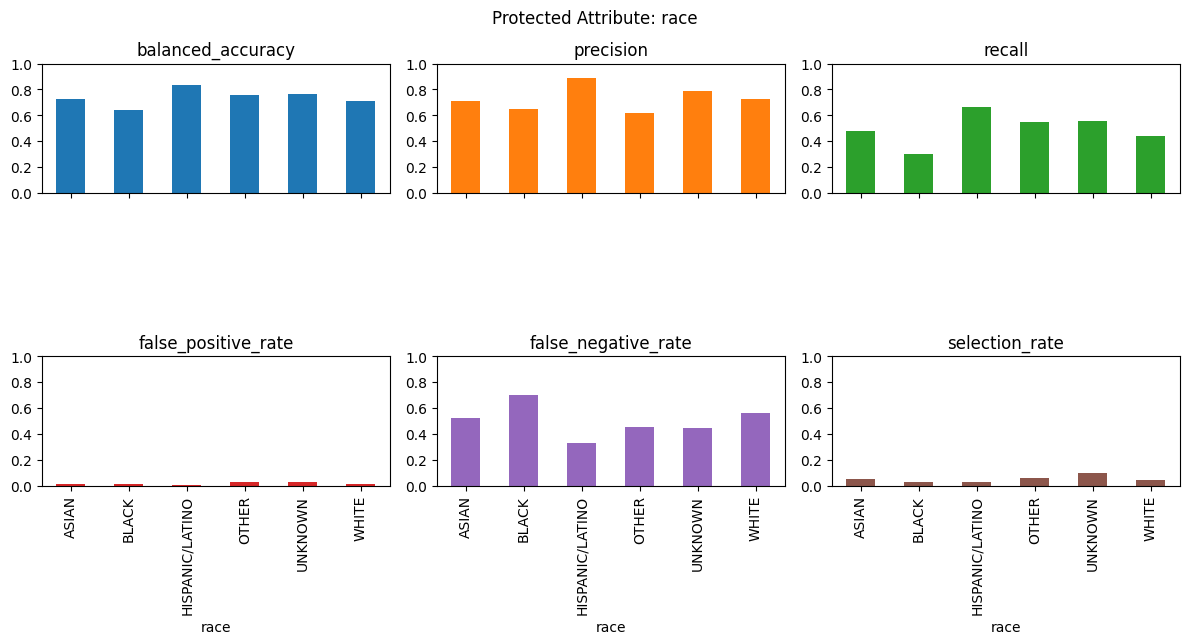

In [16]:
# Fairness Evaluation by Protected Attributes
protected_attribute = 'race'
race_unmitigated_mf, _, race_unmitigated_metrics = trainer.eval_fairness(
    estimator=estimator,
    discrete_cols=categorical_cols,
    continuous_cols=numerical_cols,
    protected_attribute=protected_attribute,
    save_path=os.path.join(save_path, 'unmitigated')
)

### **Protected Attribute: Gender**

[Fairness Evaluation: Fairness Metrics]

=== By Group ===
        balanced_accuracy  precision    recall  false_positive_rate  \
gender                                                                
F                0.712929   0.734940  0.438849             0.012991   
M                0.735517   0.731707  0.485175             0.014142   

        false_negative_rate  selection_rate  
gender                                       
F                  0.561151        0.045293  
M                  0.514825        0.048829  
Demographic Parity Difference: 0.004
Demographic Parity Ratio: 0.928
Equalized Odds Difference: 0.046
Equalized Odds Ratio: 0.905


<Figure size 800x600 with 0 Axes>

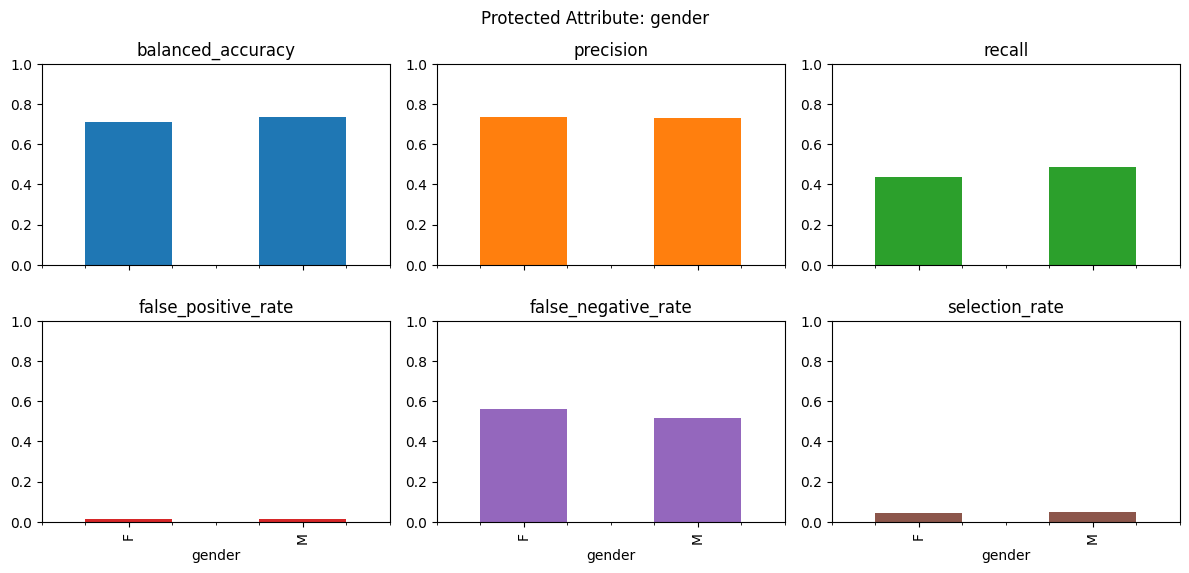

In [17]:
protected_attribute = 'gender'
gender_unmitigated_mf, _, gender_unmitigated_metrics = trainer.eval_fairness(
    estimator=estimator,
    discrete_cols=categorical_cols,
    continuous_cols=numerical_cols,
    protected_attribute=protected_attribute,
    save_path=os.path.join(save_path, 'unmitigated')
)

### **Protected Attribute: Age**

[Fairness Evaluation: Fairness Metrics]

=== By Group ===
          balanced_accuracy  precision    recall  false_positive_rate  \
age                                                                     
[18, 30)           0.679367   0.666667  0.363636             0.004902   
[30, 40)           0.841562   0.846154  0.687500             0.004376   
[40, 50)           0.744342   0.680000  0.500000             0.011315   
[50, 60)           0.780641   0.739726  0.574468             0.013185   
[60, 70)           0.698033   0.714286  0.408163             0.012097   
[70, 80)           0.734835   0.747475  0.483660             0.013990   
[80, 90)           0.699529   0.732143  0.422680             0.023622   

          false_negative_rate  selection_rate  
age                                            
[18, 30)             0.636364        0.014320  
[30, 40)             0.312500        0.027484  
[40, 50)             0.500000        0.033738  
[50, 60)             0.425532        0.04755

<Figure size 800x600 with 0 Axes>

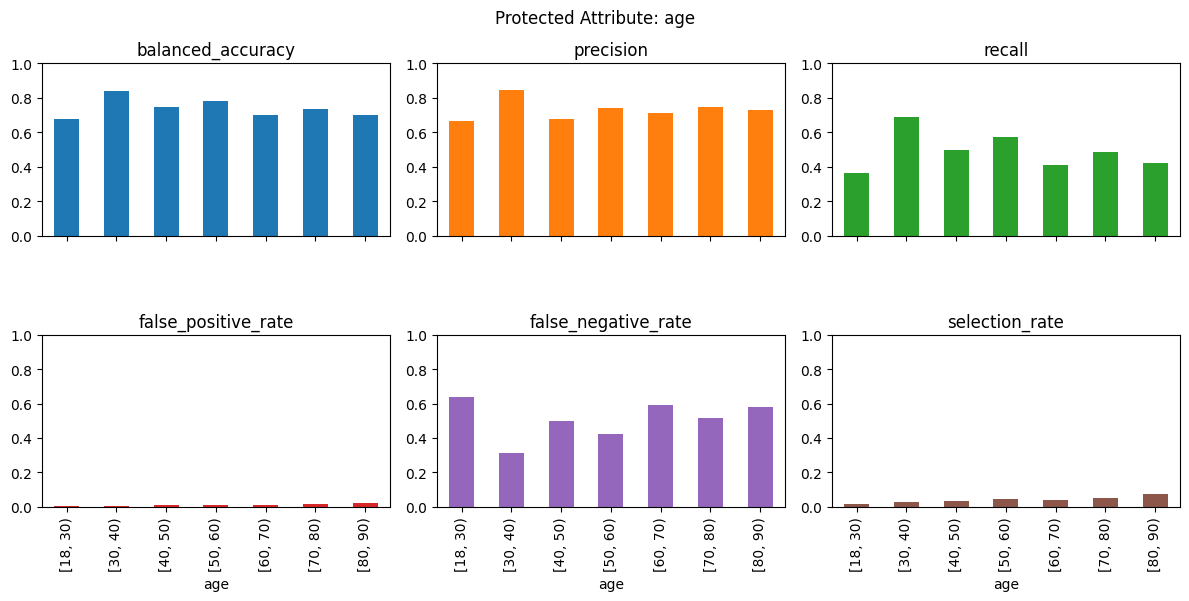

In [18]:
protected_attribute = 'age'
age_unmitigated_mf, _, age_unmitigated_metrics = trainer.eval_fairness(
    estimator=estimator,
    discrete_cols=categorical_cols,
    continuous_cols=numerical_cols,
    protected_attribute=protected_attribute,
    save_path=os.path.join(save_path, 'unmitigated')
)

### **Protected Attribute: Insurance Type**

[Fairness Evaluation: Fairness Metrics]

=== By Group ===
           balanced_accuracy  precision    recall  false_positive_rate  \
insurance                                                                
Medicaid            0.784283   0.785714  0.578947             0.010381   
Medicare            0.729122   0.733032  0.476471             0.018227   
Other               0.712404   0.723926  0.435424             0.010616   

           false_negative_rate  selection_rate  
insurance                                       
Medicaid              0.421053        0.045455  
Medicare              0.523529        0.061784  
Other                 0.564576        0.036142  
Demographic Parity Difference: 0.026
Demographic Parity Ratio: 0.585
Equalized Odds Difference: 0.144
Equalized Odds Ratio: 0.570


<Figure size 800x600 with 0 Axes>

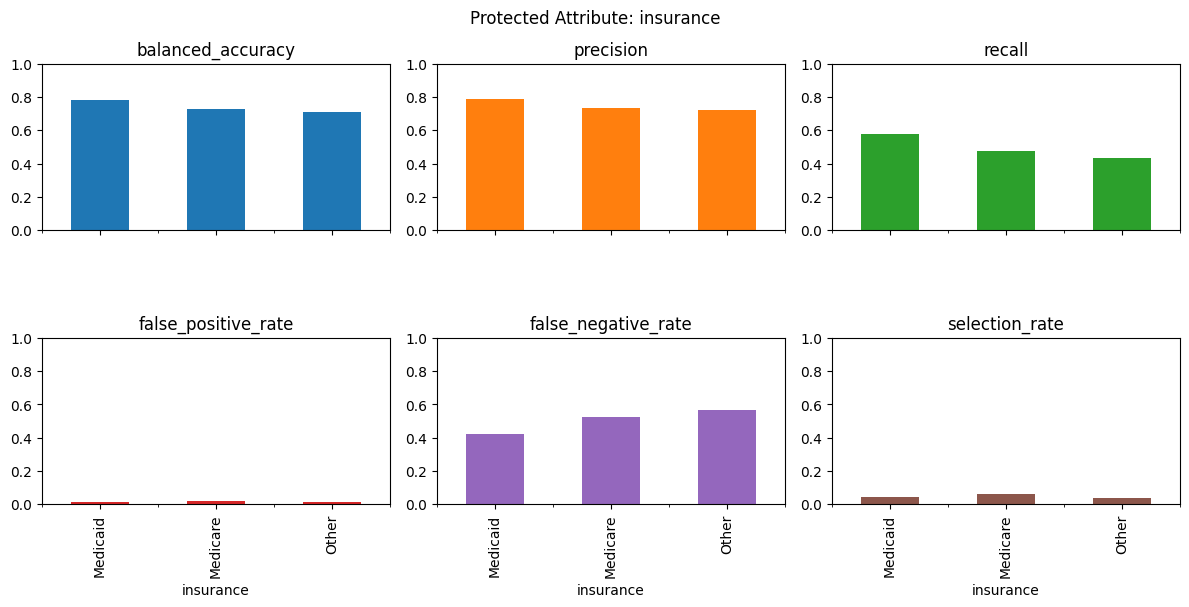

In [19]:
protected_attribute = 'insurance'
insurance_unmitigated_mf, _, insurance_unmitigated_metrics = trainer.eval_fairness(
    estimator=estimator,
    discrete_cols=categorical_cols,
    continuous_cols=numerical_cols,
    protected_attribute=protected_attribute,
    save_path=os.path.join(save_path, 'unmitigated')
)

# **3. Mitigation Algorithm**
## 1) Algorithm: Threshold Optimizer
: An algorithm that defines separate thresholds for each Protected Attribute to optimize model fairness and performance. It generates all possible thresholds and selects the best combination that satisfies the given fairness constraints.

In [20]:
threshold_opt_save_path = os.path.join(save_path, 'threshold_optimizer')

# objective: Performance goal for threshold optimization
threshold_opt_objective = 'balanced_accuracy_score'

# constraints: Fairness constraints for threshold optimization, aimed at minimizing imbalance between groups and ensuring fairness.
threshold_opt_constraints = 'equalized_odds'

### **Protected Attribute: Race**

In [21]:
protected_attribute = 'race'
threshold_opt_estimator = trainer.get_estimator(estimator=estimator, is_threshold_optimizer=True, 
                                                objective=threshold_opt_objective, constraints=threshold_opt_constraints)
threshold_opt_estimator = trainer.train(estimator=threshold_opt_estimator,
                                        discrete_cols=categorical_cols,
                                        continuous_cols=numerical_cols,
                                        protected_attribute=protected_attribute)

* The Threshold Optimizer algorithm is designed to meet specified fairness criteria, which may lower the model's performance metrics such as accuracy.

[Evaluation: Performance Metrics]

accuracy: 0.873
balanced_accuracy: 0.842
precision: 0.349
recall: 0.804
f1 score: 0.486
AUC: 0.850
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      8054
         1.0       0.35      0.80      0.49       649

    accuracy                           0.87      8703
   macro avg       0.67      0.84      0.71      8703
weighted avg       0.94      0.87      0.89      8703



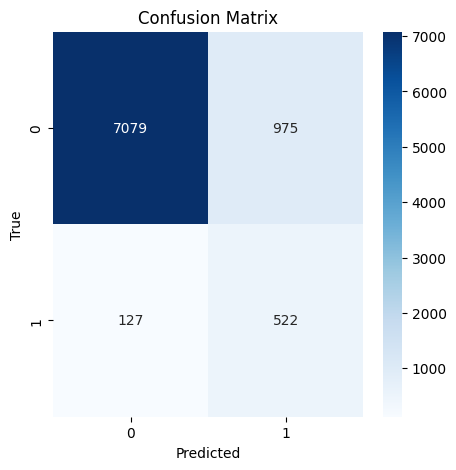

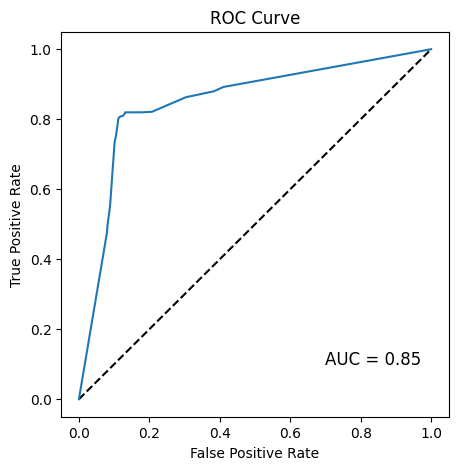

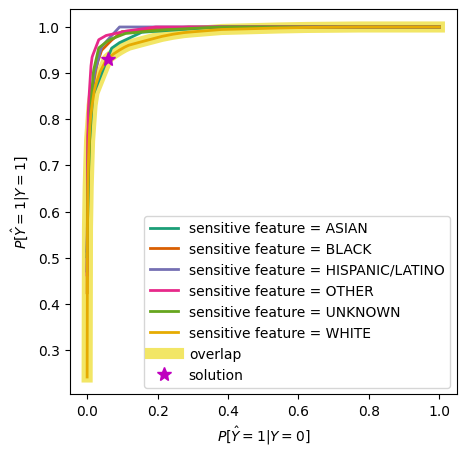

In [22]:
# Evaluate Model Performance After Applying Threshold Optimizer Algorithm
threshold_opt_estimator = trainer.eval(threshold_opt_estimator, 
                                       categorical_cols, 
                                       numerical_cols, 
                                       protected_attribute, 
                                       threshold_opt_save_path,
                                       predict_prob_method='_pmf_predict')
plt.figure(figsize=(5, 5))
plot_threshold_optimizer(threshold_opt_estimator, show_plot=False)
plt.show()

[Fairness Evaluation: Fairness Metrics]

=== By Group ===
                 balanced_accuracy  precision    recall  false_positive_rate  \
race                                                                           
ASIAN                     0.764989   0.371429  0.619048             0.089069   
BLACK                     0.809840   0.291339  0.740000             0.120321   
HISPANIC/LATINO           0.893648   0.229167  0.916667             0.129371   
OTHER                     0.888335   0.340909  0.909091             0.132420   
UNKNOWN                   0.813599   0.509091  0.746667             0.119469   
WHITE                     0.846164   0.323621  0.812010             0.119683   

                 false_negative_rate  selection_rate  
race                                                  
ASIAN                       0.380952        0.130597  
BLACK                       0.260000        0.159148  
HISPANIC/LATINO             0.083333        0.161074  
OTHER                     

<Figure size 800x600 with 0 Axes>

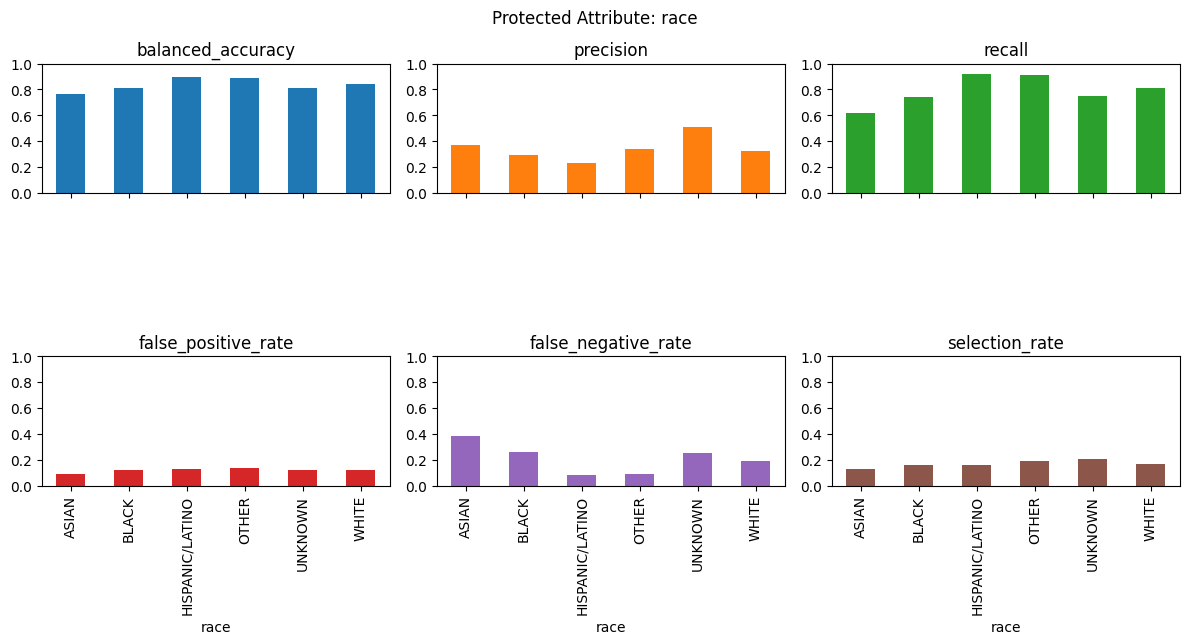

In [23]:
# Evaluate Model Fairness After Applying Threshold Optimizer Algorithm
race_postprocess_mf, _, race_postprocess_metrics = trainer.eval_fairness(threshold_opt_estimator, 
                                                                           categorical_cols, 
                                                                           numerical_cols, 
                                                                           protected_attribute, 
                                                                           threshold_opt_save_path, 
                                                                           predict_prob_method='_pmf_predict')

* Compare Maximum Absolute Differences between groups for each metric.
* Smaller values indicate less disparity between groups, suggesting that model fairness is upheld.

In [24]:
EvalFairness.compare_metric_frames(mfs=[race_unmitigated_mf, race_postprocess_mf],
                                   metrics=[race_unmitigated_metrics, race_postprocess_metrics],
                                   names=['Unmitigated', 'Threshold Optimizer'], 
                                   difference=True)

,Unmitigated,Threshold Optimizer
balanced_accuracy,0.187,0.129
precision,0.268,0.280
recall,0.367,0.298
false_positive_rate,0.022,0.043
false_negative_rate,0.367,0.298
selection_rate,0.071,0.078
equalized_odds,0.367,0.298
demographic_parity_difference,0.071,0.078


### **Protected Attribute: Gender**

In [25]:
protected_attribute = 'gender'
threshold_opt_estimator = trainer.get_estimator(estimator=estimator, is_threshold_optimizer=True, 
                                                objective=threshold_opt_objective, constraints=threshold_opt_constraints)
threshold_opt_estimator = trainer.train(estimator=threshold_opt_estimator,
                                        discrete_cols=categorical_cols,
                                        continuous_cols=numerical_cols,
                                        protected_attribute=protected_attribute)

[Evaluation: Performance Metrics]

accuracy: 0.889
balanced_accuracy: 0.846
precision: 0.382
recall: 0.797
f1 score: 0.516
AUC: 0.846
              precision    recall  f1-score   support

         0.0       0.98      0.90      0.94      8054
         1.0       0.38      0.80      0.52       649

    accuracy                           0.89      8703
   macro avg       0.68      0.85      0.73      8703
weighted avg       0.94      0.89      0.91      8703



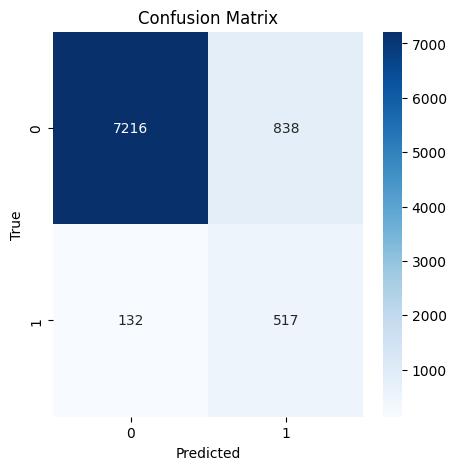

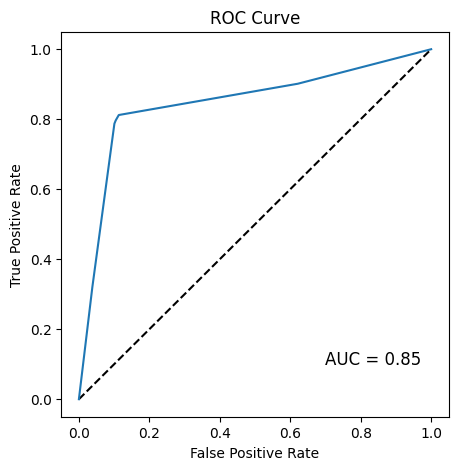

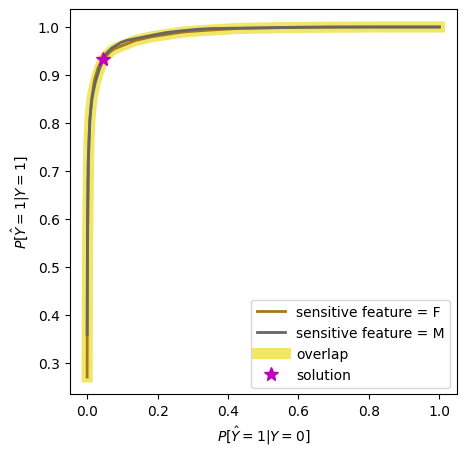

In [26]:
threshold_opt_estimator = trainer.eval(threshold_opt_estimator, 
                                       categorical_cols, 
                                       numerical_cols, 
                                       protected_attribute, 
                                       threshold_opt_save_path,
                                       predict_prob_method='_pmf_predict')
plt.figure(figsize=(5, 5))
plot_threshold_optimizer(threshold_opt_estimator, show_plot=False)
plt.show()

[Fairness Evaluation: Fairness Metrics]

=== By Group ===
        balanced_accuracy  precision    recall  false_positive_rate  \
gender                                                                
F                0.828539   0.386740  0.755396             0.098317   
M                0.853717   0.372694  0.816712             0.109278   

        false_negative_rate  selection_rate  
gender                                       
F                  0.244604        0.148158  
M                  0.183288        0.161374  
Demographic Parity Difference: 0.013
Demographic Parity Ratio: 0.918
Equalized Odds Difference: 0.061
Equalized Odds Ratio: 0.900


<Figure size 800x600 with 0 Axes>

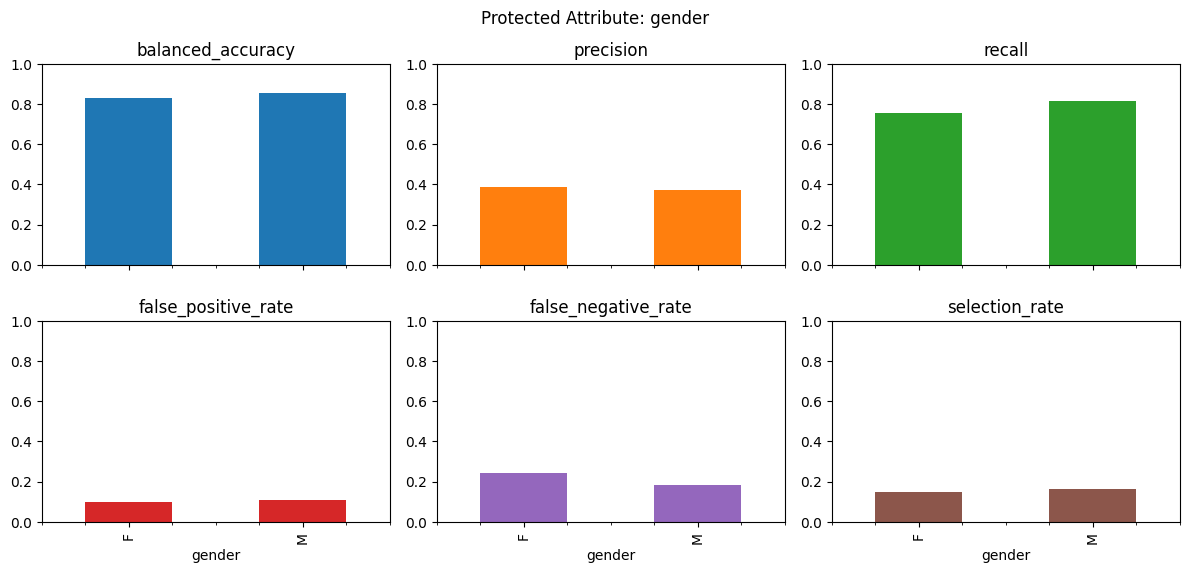

In [27]:
gender_postprocess_mf, _, gender_postprocess_metrics = trainer.eval_fairness(threshold_opt_estimator, 
                                                                               categorical_cols, 
                                                                               numerical_cols, 
                                                                               protected_attribute, 
                                                                               threshold_opt_save_path, 
                                                                               predict_prob_method='_pmf_predict')

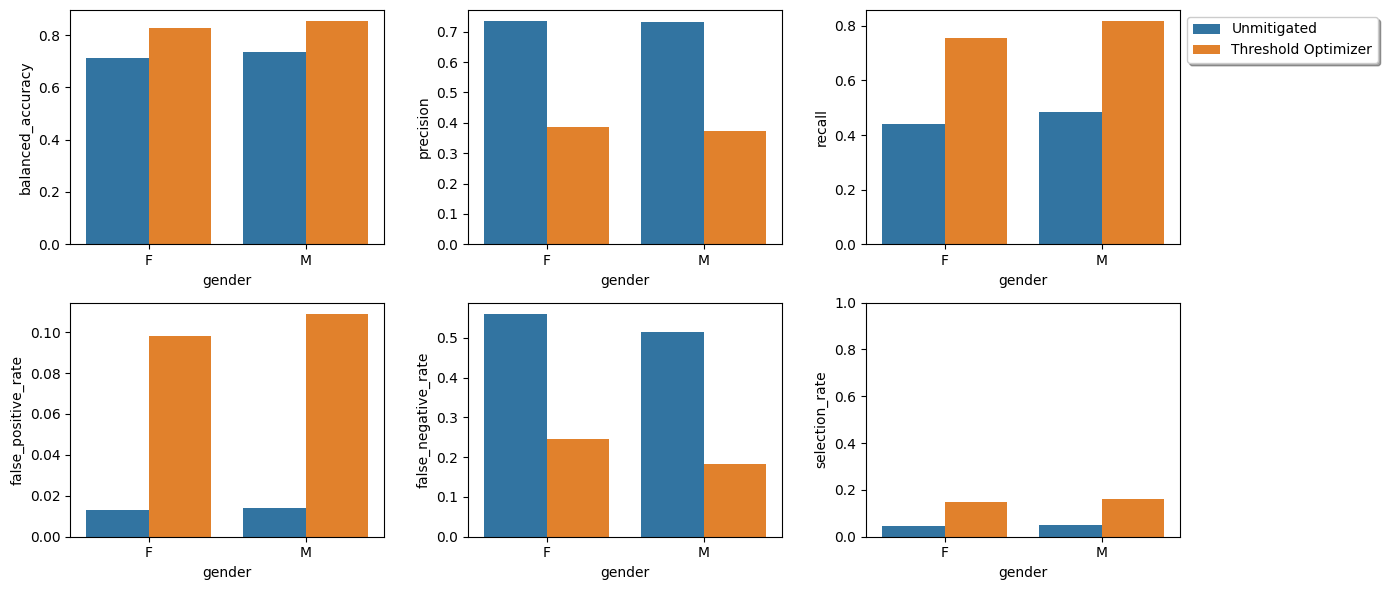

Unmitigated        Threshold Optimizer       
                              F      M                   F      M
balanced_accuracy         0.713  0.736               0.829  0.854
precision                 0.735  0.732               0.387  0.373
recall                    0.439  0.485               0.755  0.817
false_positive_rate       0.013  0.014               0.098  0.109
false_negative_rate       0.561  0.515               0.245  0.183
selection_rate            0.045  0.049               0.148  0.161

In [28]:
res = EvalFairness.compare_metric_frames(mfs=[gender_unmitigated_mf, gender_postprocess_mf],
                                   metrics=[gender_unmitigated_metrics, gender_postprocess_metrics],
                                   names=['Unmitigated', 'Threshold Optimizer'], 
                                   difference=False)
VisualizationFairness.plot_compare_metric_frames(res, protected_attribute=protected_attribute)
res

In [29]:
EvalFairness.compare_metric_frames(mfs=[gender_unmitigated_mf, gender_postprocess_mf],
                                   metrics=[gender_unmitigated_metrics, gender_postprocess_metrics],
                                   names=['Unmitigated', 'Threshold Optimizer'], 
                                   difference=True)

,Unmitigated,Threshold Optimizer
balanced_accuracy,0.023,0.025
precision,0.003,0.014
recall,0.046,0.061
false_positive_rate,0.001,0.011
false_negative_rate,0.046,0.061
selection_rate,0.004,0.013
equalized_odds,0.046,0.061
demographic_parity_difference,0.004,0.013


### **Protected Attribute: Age**

In [30]:
protected_attribute = 'age'
threshold_opt_estimator = trainer.get_estimator(estimator=estimator, is_threshold_optimizer=True, 
                                                objective=threshold_opt_objective, constraints=threshold_opt_constraints)
threshold_opt_estimator = trainer.train(estimator=threshold_opt_estimator,
                                        discrete_cols=categorical_cols,
                                        continuous_cols=numerical_cols,
                                        protected_attribute=protected_attribute)

[Evaluation: Performance Metrics]

accuracy: 0.870
balanced_accuracy: 0.817
precision: 0.335
recall: 0.755
f1 score: 0.464
AUC: 0.815
              precision    recall  f1-score   support

         0.0       0.98      0.88      0.93      8054
         1.0       0.33      0.76      0.46       649

    accuracy                           0.87      8703
   macro avg       0.66      0.82      0.69      8703
weighted avg       0.93      0.87      0.89      8703



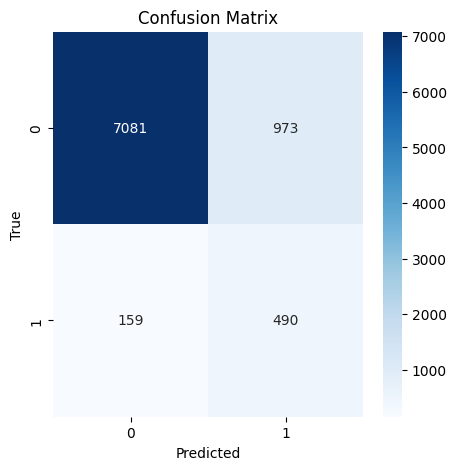

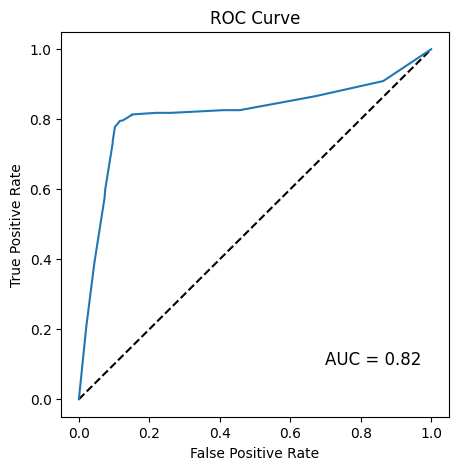

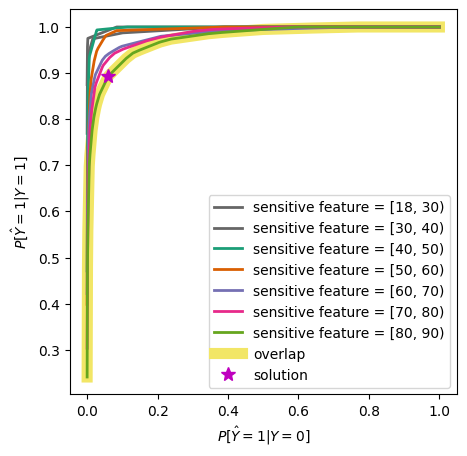

In [31]:
threshold_opt_estimator = trainer.eval(threshold_opt_estimator, 
                                       categorical_cols, 
                                       numerical_cols, 
                                       protected_attribute, 
                                       threshold_opt_save_path,
                                       predict_prob_method='_pmf_predict')
plt.figure(figsize=(5, 5))
plot_threshold_optimizer(threshold_opt_estimator, show_plot=False)
plt.show()

[Fairness Evaluation: Fairness Metrics]

=== By Group ===
          balanced_accuracy  precision    recall  false_positive_rate  \
age                                                                     
[18, 30)           0.763035   0.134615  0.636364             0.110294   
[30, 40)           0.884984   0.225806  0.875000             0.105033   
[40, 50)           0.764831   0.209524  0.647059             0.117397   
[50, 60)           0.828732   0.283525  0.787234             0.129771   
[60, 70)           0.841885   0.333333  0.802721             0.118952   
[70, 80)           0.835179   0.349570  0.797386             0.127029   
[80, 90)           0.777035   0.443333  0.685567             0.131496   

          false_negative_rate  selection_rate  
age                                            
[18, 30)             0.363636        0.124105  
[30, 40)             0.125000        0.131078  
[40, 50)             0.352941        0.141700  
[50, 60)             0.212766        0.17003

<Figure size 800x600 with 0 Axes>

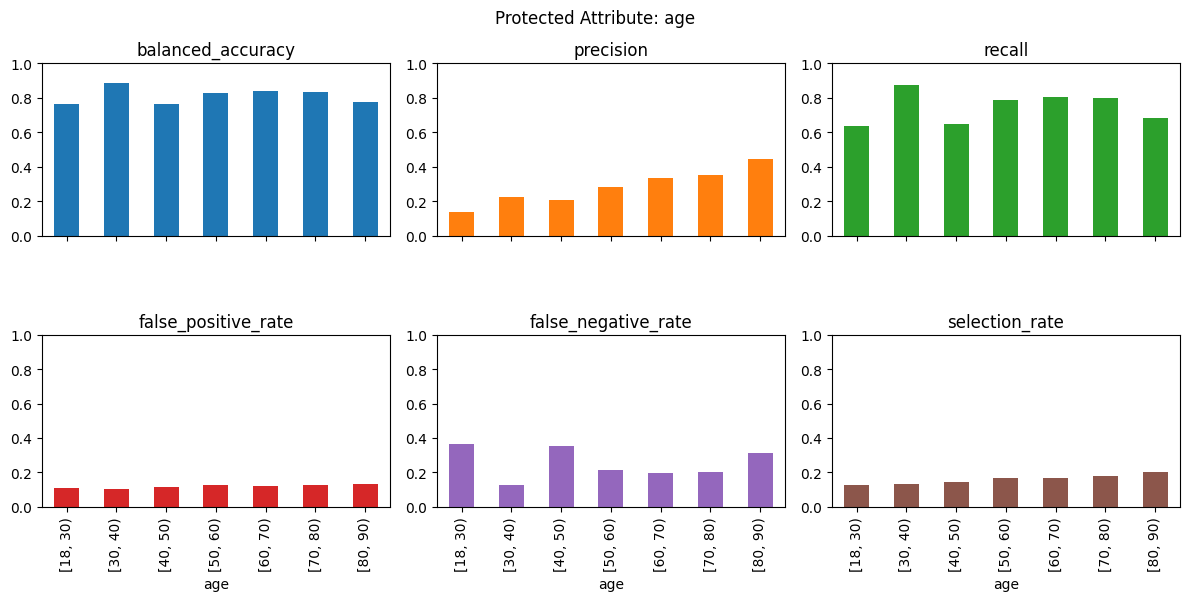

In [32]:
age_postprocess_mf, _, age_postprocess_metrics = trainer.eval_fairness(threshold_opt_estimator, 
                                                                       categorical_cols, 
                                                                       numerical_cols, 
                                                                       protected_attribute, 
                                                                       threshold_opt_save_path, 
                                                                       predict_prob_method='_pmf_predict')

In [33]:
EvalFairness.compare_metric_frames(mfs=[age_unmitigated_mf, age_postprocess_mf],
                                   metrics=[age_unmitigated_metrics, age_postprocess_metrics],
                                   names=['Unmitigated', 'Threshold Optimizer'], 
                                   difference=True)

,Unmitigated,Threshold Optimizer
balanced_accuracy,0.162,0.122
precision,0.179,0.309
recall,0.324,0.239
false_positive_rate,0.019,0.026
false_negative_rate,0.324,0.239
selection_rate,0.062,0.081
equalized_odds,0.324,0.239
demographic_parity_difference,0.062,0.081


### **Protected Attribute: Insurance Type**

In [34]:
protected_attribute = 'insurance'
threshold_opt_estimator = trainer.get_estimator(estimator=estimator, is_threshold_optimizer=True,
                                                objective=threshold_opt_objective, constraints=threshold_opt_constraints)
threshold_opt_estimator = trainer.train(estimator=threshold_opt_estimator,
                                        discrete_cols=categorical_cols,
                                        continuous_cols=numerical_cols,
                                        protected_attribute=protected_attribute)

[Evaluation: Performance Metrics]

accuracy: 0.885
balanced_accuracy: 0.840
precision: 0.372
recall: 0.786
f1 score: 0.505
AUC: 0.836
              precision    recall  f1-score   support

         0.0       0.98      0.89      0.94      8054
         1.0       0.37      0.79      0.51       649

    accuracy                           0.89      8703
   macro avg       0.68      0.84      0.72      8703
weighted avg       0.94      0.89      0.90      8703



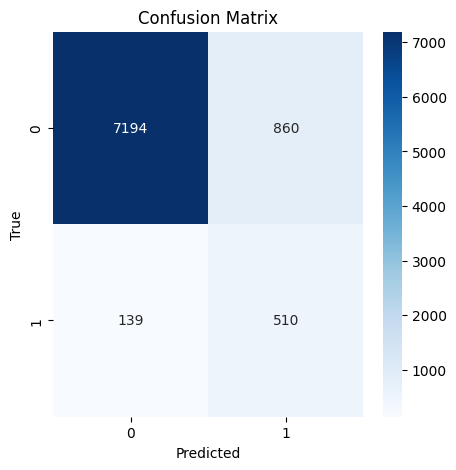

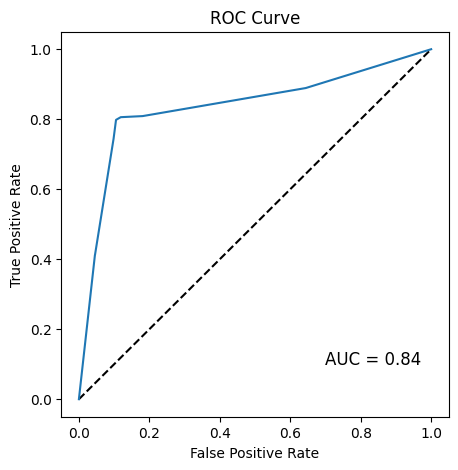

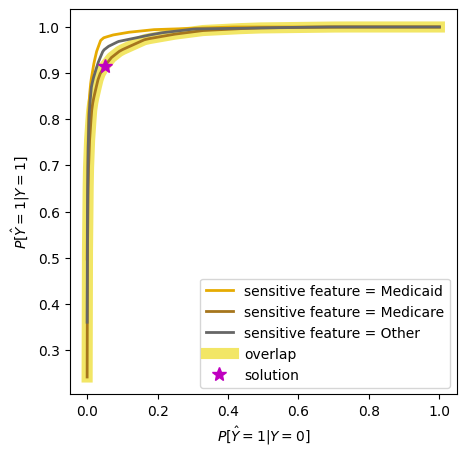

In [35]:
threshold_opt_estimator = trainer.eval(threshold_opt_estimator, 
                                       categorical_cols, 
                                       numerical_cols, 
                                       protected_attribute, 
                                       threshold_opt_save_path,
                                       predict_prob_method='_pmf_predict')
plt.figure(figsize=(5, 5))
plot_threshold_optimizer(threshold_opt_estimator, show_plot=False)
plt.show()

[Fairness Evaluation: Fairness Metrics]

=== By Group ===
           balanced_accuracy  precision    recall  false_positive_rate  \
insurance                                                                
Medicaid            0.884903   0.366667  0.868421             0.098616   
Medicare            0.837120   0.420722  0.788235             0.113994   
Other               0.829118   0.322884  0.760148             0.101911   

           false_negative_rate  selection_rate  
insurance                                       
Medicaid              0.131579        0.146104  
Medicare              0.211765        0.178082  
Other                 0.239852        0.141463  
Demographic Parity Difference: 0.037
Demographic Parity Ratio: 0.794
Equalized Odds Difference: 0.108
Equalized Odds Ratio: 0.865


<Figure size 800x600 with 0 Axes>

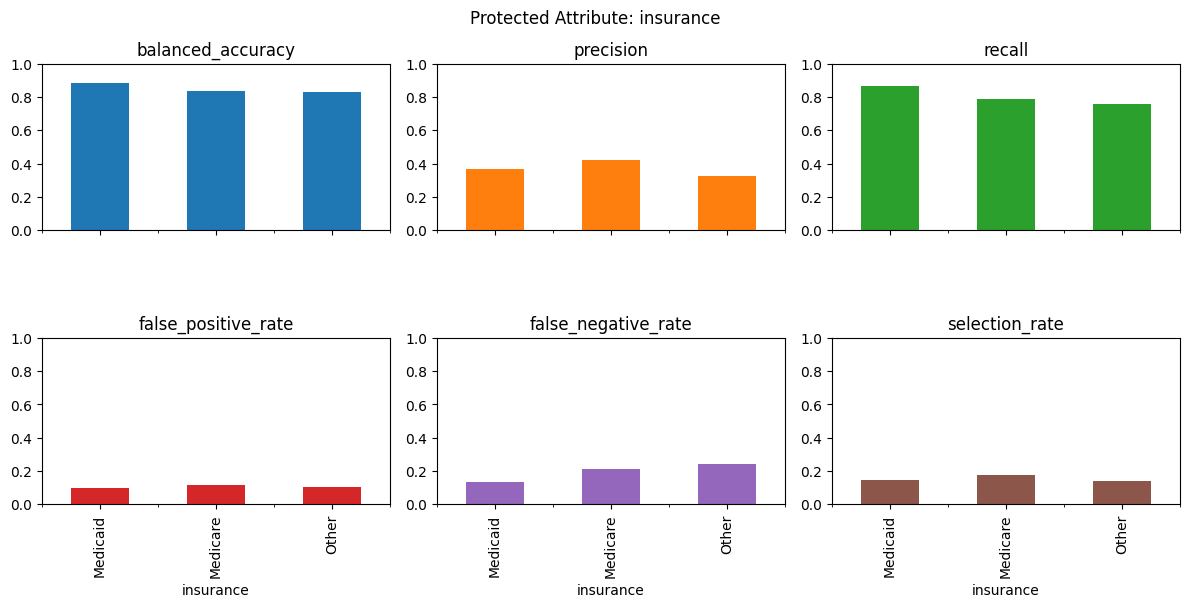

In [36]:
insurance_postprocess_mf, _, insurance_postprocess_metrics = trainer.eval_fairness(threshold_opt_estimator, 
                                                                                   categorical_cols, 
                                                                                   numerical_cols, 
                                                                                   protected_attribute, 
                                                                                   threshold_opt_save_path, 
                                                                                   predict_prob_method='_pmf_predict')

In [37]:
EvalFairness.compare_metric_frames(mfs=[insurance_unmitigated_mf, insurance_postprocess_mf],
                                   metrics=[insurance_unmitigated_metrics, insurance_postprocess_metrics],
                                   names=['Unmitigated', 'Threshold Optimizer'], 
                                   difference=True)

,Unmitigated,Threshold Optimizer
balanced_accuracy,0.072,0.056
precision,0.062,0.098
recall,0.144,0.108
false_positive_rate,0.008,0.015
false_negative_rate,0.144,0.108
selection_rate,0.026,0.037
equalized_odds,0.144,0.108
demographic_parity_difference,0.026,0.037


## 2) Algorithm: Exponentiated Gradient
: An algorithm that simultaneously optimizes a given loss function and fairness constraints. It adjusts the weights of each group when updating weights, minimizing loss while satisfying fairness goals.

In [38]:
exp_grad_save_path = os.path.join(save_path, 'exponentiated_gradient')

### **Protected Attribute: Race**

#### Selecting the Best Model with Exponentiated Gradient Algorithm
* 1) Filtering: Remove models with an error rate higher than the model before applying the mitigation algorithm.
* 2) Fairness Metric Evaluation: Among the models that satisfy step 1, select the best model based on the fairness metric (choose the model with the smallest equalized odds difference).

Epsilon for best model: 0.02, Index number: 2.0


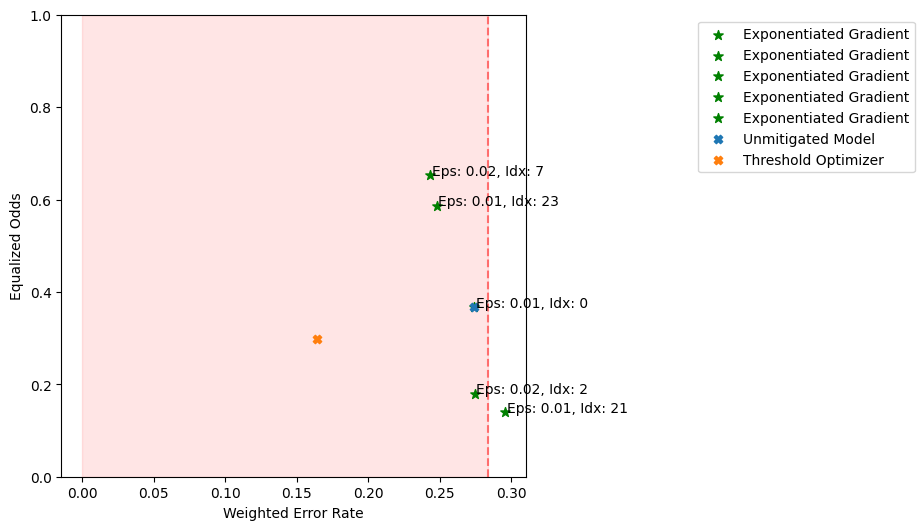

In [39]:
protected_attribute = 'race'

# Constraint: EqualizedOdds
all_models = trainer.train_exponentiated_gradient(estimator=estimator,
                                                  discrete_cols=categorical_cols,
                                                  continuous_cols=numerical_cols,
                                                  protected_attribute=protected_attribute)
exp_grad_estimator = trainer.get_best_estimator(all_models=all_models, 
                                                discrete_cols=categorical_cols,
                                                continuous_cols=numerical_cols, 
                                                protected_attribute=protected_attribute, 
                                                unmitigated_metrics=race_unmitigated_metrics, 
                                                postprocess_metrics=race_postprocess_metrics,
                                                save_path=exp_grad_save_path)

[Evaluation: Performance Metrics]

accuracy: 0.947
balanced_accuracy: 0.725
precision: 0.722
recall: 0.465
f1 score: 0.566
AUC: 0.923
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      8054
         1.0       0.72      0.47      0.57       649

    accuracy                           0.95      8703
   macro avg       0.84      0.73      0.77      8703
weighted avg       0.94      0.95      0.94      8703



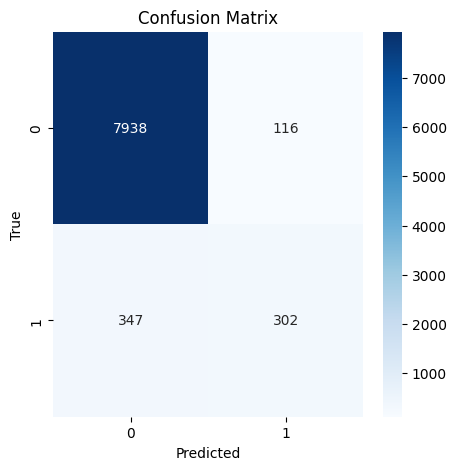

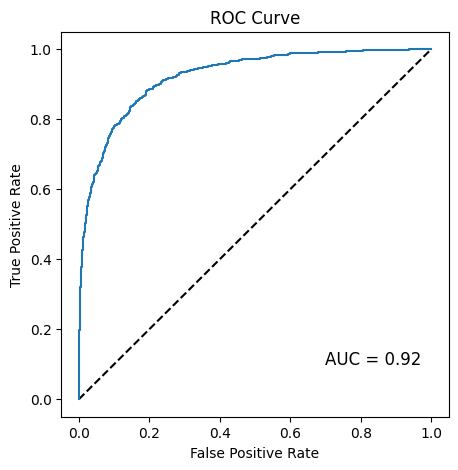

In [40]:
exp_grad_estimator = trainer.eval(exp_grad_estimator, categorical_cols, numerical_cols, protected_attribute, exp_grad_save_path)

[Fairness Evaluation: Fairness Metrics]

=== By Group ===
                 balanced_accuracy  precision    recall  false_positive_rate  \
race                                                                           
ASIAN                     0.708213   0.750000  0.428571             0.012146   
BLACK                     0.665321   0.708333  0.340000             0.009358   
HISPANIC/LATINO           0.750000   1.000000  0.500000             0.000000   
OTHER                     0.743877   0.586207  0.515152             0.027397   
UNKNOWN                   0.750597   0.821053  0.520000             0.018805   
WHITE                     0.721371   0.694444  0.456919             0.014178   

                 false_negative_rate  selection_rate  
race                                                  
ASIAN                       0.571429        0.044776  
BLACK                       0.660000        0.030075  
HISPANIC/LATINO             0.500000        0.020134  
OTHER                     

<Figure size 800x600 with 0 Axes>

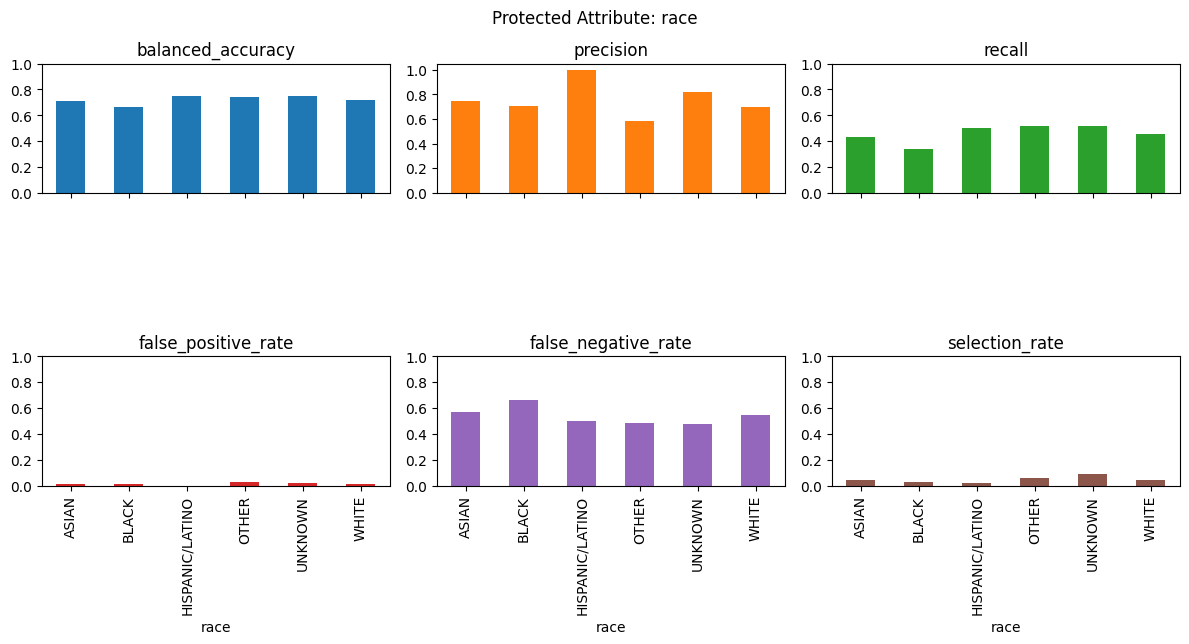

In [41]:
race_exp_grad_mf, _, race_exp_grad_metrics = trainer.eval_fairness(exp_grad_estimator, categorical_cols, numerical_cols, protected_attribute, exp_grad_save_path)

* The table below shows the **Maximum Absolute Difference** between groups for each metric.
* **It can be observed that when using the Exponentiated Gradient algorithm, the overall differences in metrics between groups are the smallest.**

In [42]:
EvalFairness.compare_metric_frames(mfs=[race_unmitigated_mf, race_postprocess_mf, race_exp_grad_mf],
                                   metrics=[race_unmitigated_metrics, race_postprocess_metrics, race_exp_grad_metrics],
                                   names=['Unmitigated', 'ThresholdOptimizer', 'ExponentiatedGradient'], 
                                   difference=True)

,Unmitigated,ThresholdOptimizer,ExponentiatedGradient
balanced_accuracy,0.187,0.129,0.085
precision,0.268,0.280,0.414
recall,0.367,0.298,0.180
false_positive_rate,0.022,0.043,0.027
false_negative_rate,0.367,0.298,0.180
selection_rate,0.071,0.078,0.070
equalized_odds,0.367,0.298,0.180
demographic_parity_difference,0.071,0.078,0.070


### **Protected Attribute: Gender**

Epsilon for best model: 0.01, Index number: 1.0


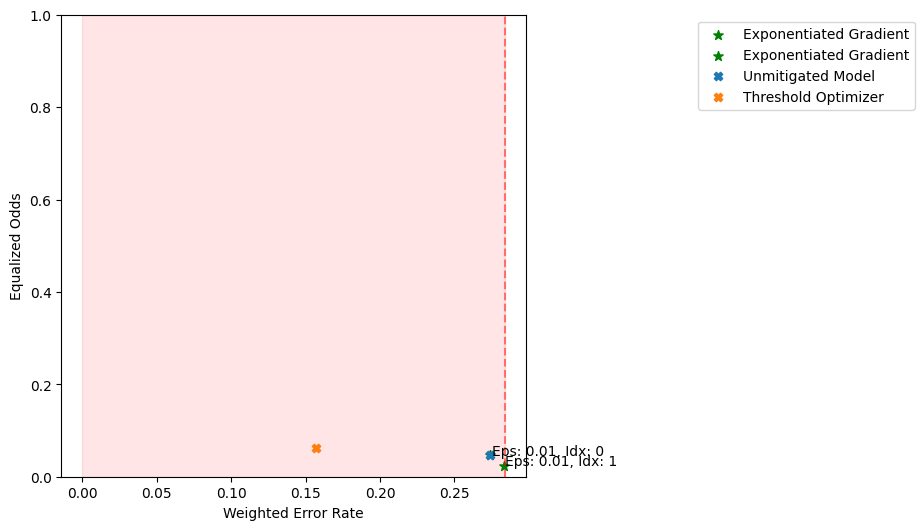

In [43]:
protected_attribute = 'gender'
all_models = trainer.train_exponentiated_gradient(estimator=estimator,
                                                  discrete_cols=categorical_cols,
                                                  continuous_cols=numerical_cols,
                                                  protected_attribute=protected_attribute)
exp_grad_estimator = trainer.get_best_estimator(all_models=all_models, 
                                                discrete_cols=categorical_cols,
                                                continuous_cols=numerical_cols, 
                                                protected_attribute=protected_attribute, 
                                                unmitigated_metrics=gender_unmitigated_metrics, 
                                                postprocess_metrics=gender_postprocess_metrics,
                                                save_path=exp_grad_save_path)

[Evaluation: Performance Metrics]

accuracy: 0.948
balanced_accuracy: 0.717
precision: 0.757
recall: 0.445
f1 score: 0.561
AUC: 0.929
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      8054
         1.0       0.76      0.45      0.56       649

    accuracy                           0.95      8703
   macro avg       0.86      0.72      0.77      8703
weighted avg       0.94      0.95      0.94      8703



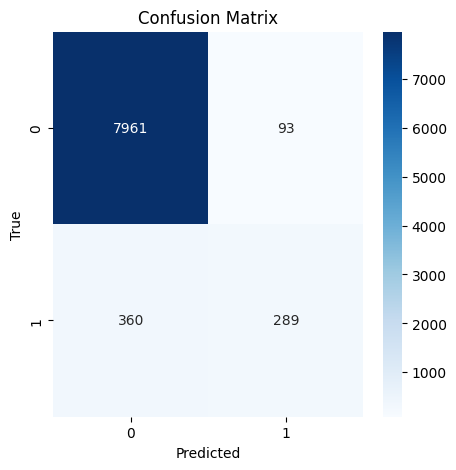

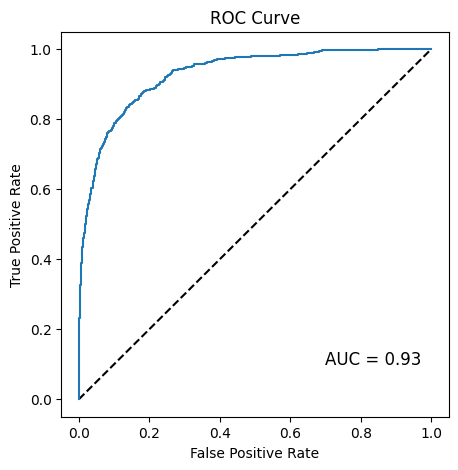

In [44]:
exp_grad_estimator = trainer.eval(exp_grad_estimator, categorical_cols, numerical_cols, protected_attribute, exp_grad_save_path)

[Fairness Evaluation: Fairness Metrics]

=== By Group ===
        balanced_accuracy  precision    recall  false_positive_rate  \
gender                                                                
F                0.710218   0.759494  0.431655             0.011219   
M                0.721870   0.754464  0.455526             0.011785   

        false_negative_rate  selection_rate  
gender                                       
F                  0.568345        0.043111  
M                  0.544474        0.044462  
Demographic Parity Difference: 0.001
Demographic Parity Ratio: 0.970
Equalized Odds Difference: 0.024
Equalized Odds Ratio: 0.948


<Figure size 800x600 with 0 Axes>

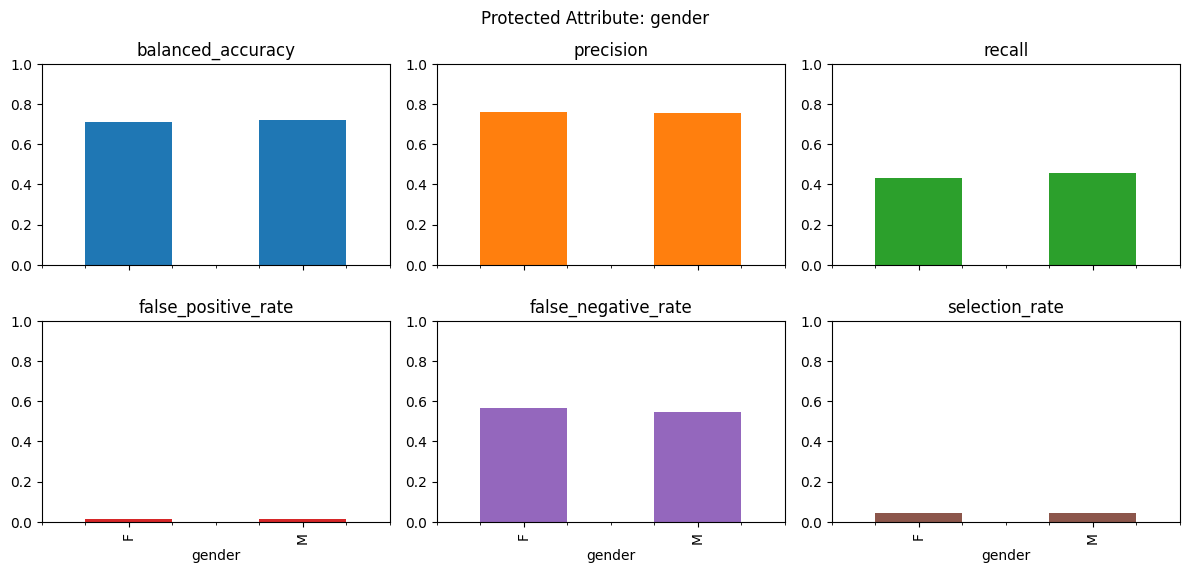

In [45]:
gender_exp_grad_mf, _, gender_exp_grad_metrics = trainer.eval_fairness(exp_grad_estimator, categorical_cols, numerical_cols, protected_attribute, exp_grad_save_path)

In [46]:
EvalFairness.compare_metric_frames(mfs=[gender_unmitigated_mf, gender_postprocess_mf, gender_exp_grad_mf],
                                   metrics=[gender_unmitigated_metrics, gender_postprocess_metrics, gender_exp_grad_metrics],
                                   names=['Unmitigated', 'ThresholdOptimizer', 'ExponentiatedGradient'], 
                                   difference=True)

,Unmitigated,ThresholdOptimizer,ExponentiatedGradient
balanced_accuracy,0.023,0.025,0.012
precision,0.003,0.014,0.005
recall,0.046,0.061,0.024
false_positive_rate,0.001,0.011,0.001
false_negative_rate,0.046,0.061,0.024
selection_rate,0.004,0.013,0.001
equalized_odds,0.046,0.061,0.024
demographic_parity_difference,0.004,0.013,0.001


### **Protected Attribute: Age**

Epsilon for best model: 0.01, Index number: 0.0


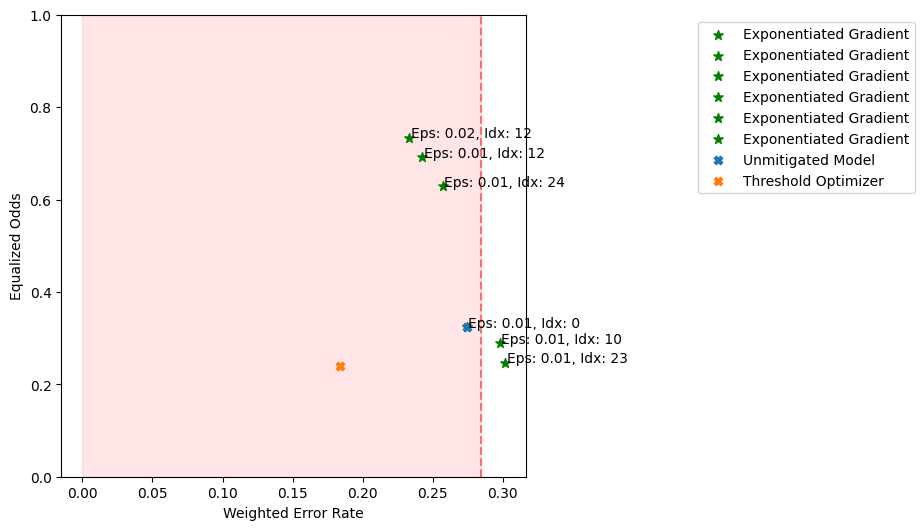

In [47]:
protected_attribute = 'age'
all_models = trainer.train_exponentiated_gradient(estimator=estimator,
                                                  discrete_cols=categorical_cols,
                                                  continuous_cols=numerical_cols,
                                                  protected_attribute=protected_attribute)
exp_grad_estimator = trainer.get_best_estimator(all_models=all_models, 
                                                discrete_cols=categorical_cols,
                                                continuous_cols=numerical_cols, 
                                                protected_attribute=protected_attribute, 
                                                unmitigated_metrics=age_unmitigated_metrics, 
                                                postprocess_metrics=age_postprocess_metrics,
                                                save_path=exp_grad_save_path)

[Evaluation: Performance Metrics]

accuracy: 0.947
balanced_accuracy: 0.726
precision: 0.733
recall: 0.465
f1 score: 0.569
AUC: 0.929
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      8054
         1.0       0.73      0.47      0.57       649

    accuracy                           0.95      8703
   macro avg       0.85      0.73      0.77      8703
weighted avg       0.94      0.95      0.94      8703



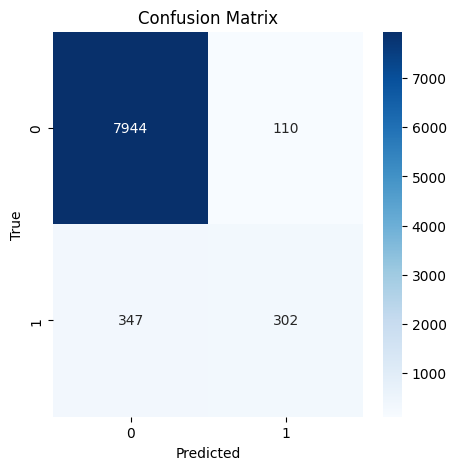

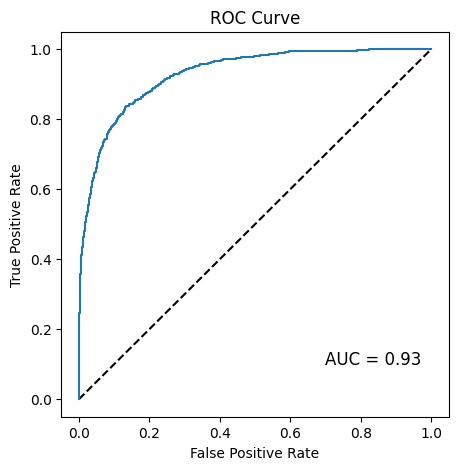

In [48]:
exp_grad_estimator = trainer.eval(exp_grad_estimator, categorical_cols, numerical_cols, protected_attribute, exp_grad_save_path)

[Fairness Evaluation: Fairness Metrics]

=== By Group ===
          balanced_accuracy  precision    recall  false_positive_rate  \
age                                                                     
[18, 30)           0.679367   0.666667  0.363636             0.004902   
[30, 40)           0.841562   0.846154  0.687500             0.004376   
[40, 50)           0.744342   0.680000  0.500000             0.011315   
[50, 60)           0.780641   0.739726  0.574468             0.013185   
[60, 70)           0.698033   0.714286  0.408163             0.012097   
[70, 80)           0.734835   0.747475  0.483660             0.013990   
[80, 90)           0.699529   0.732143  0.422680             0.023622   

          false_negative_rate  selection_rate  
age                                            
[18, 30)             0.636364        0.014320  
[30, 40)             0.312500        0.027484  
[40, 50)             0.500000        0.033738  
[50, 60)             0.425532        0.04755

<Figure size 800x600 with 0 Axes>

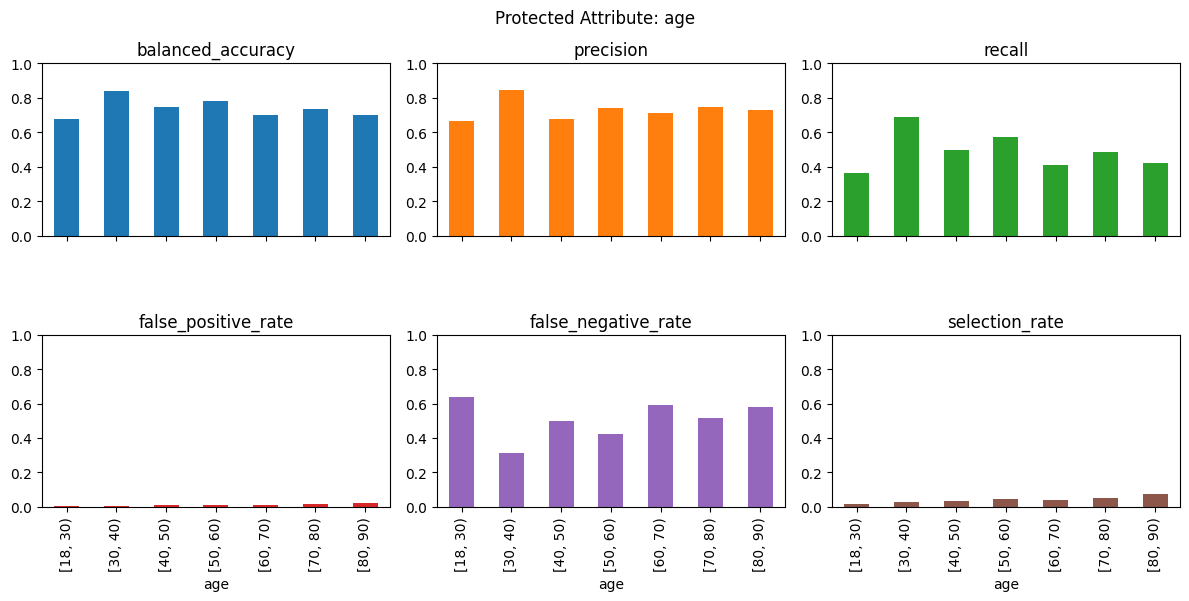

In [49]:
age_exp_grad_mf, _, age_exp_grad_metrics = trainer.eval_fairness(exp_grad_estimator, categorical_cols, numerical_cols, protected_attribute, exp_grad_save_path)

In [50]:
EvalFairness.compare_metric_frames(mfs=[age_unmitigated_mf, age_postprocess_mf, age_exp_grad_mf],
                                   metrics=[age_unmitigated_metrics, age_postprocess_metrics, age_exp_grad_metrics],
                                   names=['Unmitigated', 'ThresholdOptimizer', 'ExponentiatedGradient'], 
                                   difference=True)

,Unmitigated,ThresholdOptimizer,ExponentiatedGradient
balanced_accuracy,0.162,0.122,0.162
precision,0.179,0.309,0.179
recall,0.324,0.239,0.324
false_positive_rate,0.019,0.026,0.019
false_negative_rate,0.324,0.239,0.324
selection_rate,0.062,0.081,0.062
equalized_odds,0.324,0.239,0.324
demographic_parity_difference,0.062,0.081,0.062


### **Protected Attribute: Insurance Type**

In [ ]:
protected_attribute = 'insurance'
all_models = trainer.train_exponentiated_gradient(estimator=estimator,
                                                  discrete_cols=categorical_cols,
                                                  continuous_cols=numerical_cols,
                                                  protected_attribute=protected_attribute)
exp_grad_estimator = trainer.get_best_estimator(all_models=all_models, 
                                                discrete_cols=categorical_cols,
                                                continuous_cols=numerical_cols, 
                                                protected_attribute=protected_attribute, 
                                                unmitigated_metrics=insurance_unmitigated_metrics, 
                                                postprocess_metrics=insurance_postprocess_metrics,
                                                save_path=exp_grad_save_path)

In [ ]:
exp_grad_estimator = trainer.eval(exp_grad_estimator, categorical_cols, numerical_cols, protected_attribute, exp_grad_save_path)

In [ ]:
insurance_exp_grad_mf, _, insurance_exp_grad_metrics = trainer.eval_fairness(exp_grad_estimator, categorical_cols, numerical_cols, protected_attribute, exp_grad_save_path)

In [ ]:
EvalFairness.compare_metric_frames(mfs=[insurance_unmitigated_mf, insurance_postprocess_mf, insurance_exp_grad_mf],
                                   metrics=[insurance_unmitigated_metrics, insurance_postprocess_metrics, insurance_exp_grad_metrics],
                                   names=['Unmitigated', 'ThresholdOptimizer', 'ExponentiatedGradient'], 
                                   difference=True)